# Biodiversity Intactness Index Change in Phoenix, AZ (2017-2020)

### By Kaiju Morquecho

[Github Repository](https://github.com/kaimorquecho/eds220_biodiversity_phoenix_az.git)

### Repository Structure 
```
├── .gitignore
├── biodiversity_intactness_arizona.ipynb
├── README.md
└── data  
    │   tl_2020_04_countsub
        | tl_2020_04_countsub.shp
```

### About

This repository will investigate the impacts of urban expansion by analyzing a dataset that captures values for the Biodiversity Intactness Index (BII). The analysis finds changes in BII in the Phoenix county subdivision area between 2017 and 2020 to demonstrate on how urban growth affects biodiversity over time. The analysis is a result of the final project for course EDS 220, Working with Environmental Datasets, taught by Dr. Carmen Galaz Garcia and TA Annie Adams.

### Data

- The **Biodiversity Intactness Index (BII) Time Series** is a biodiversity indicator that measures changes in biodiversity using abudance data on plants, fungi, and animals. As a time series, the **BII** captures the effects of human interaction and resource use on species abundance over time. The **BII** collection, ID `io-biodiversity` can be accessed by signining into the **[Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)** using the `pystac-client` library to query the STAC API. The `planetary computer` signs items.

- The Phoenix, AZ subdivision area polygon is obtained from the U.S Census Bureau TIGER Shapefile of Arizona County Subdivisions, and is used to outline the area of interest in this analysis. The data can be accessed on the [Data.gov website](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision) and is tittled 'TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions'.

### References 
Microsoft Planetary Computer. (n.d.). io-biodiversity [STAC collection]. Accessed December 4, 2025, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau. (2021). TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions [Data set]. Data.gov. Accessed December 4, 2025, from https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision
 


### Import Libraries and Load Datasets

Aside from the standard libraries such as `numpy` and `matplotlib`, the following specialized libraries were used in this analysis:
- `xarray` to access and analyze netCDF4 files (multidimensional datasets)
- `rioxarray` to extend `xarray` with the `rio` accessor to read and manipulate raster data 
- `contextily` to add basemaps to geospatial visualizations
- `geopandas` to handle vector data such as shapefiles
- `planetary_computer` and `pystac_client` to sign into and retrieve items from the Microsoft Planetary Computer STAC 

In [31]:
# Load libraries 
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import contextily as ctx # For a basemap
import matplotlib.patches as mpatches


from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from MPC STAC

from IPython.display import Image # For nicer image display

### Access the Biodiversity Intactness Index Collection 

To begin working with the Biodiversity Intactness data, I first connect to the Microsoft Planetary Computer (MPC) STAC API using `Client.open`, which allows me to search and retrieve the geospatial datasets. Because I am specifically interested in changes within Phoenix, Arizona, I define a bounding box of the geographic extent of the Phoenix subdivision. I also specify the years I want to examine (2017 and 2020), since the `io-biodiversity` collection includes multiple years of data.

In [2]:
# Access MPC catalog 
catalog = Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1",
modifier=planetary_computer.sign_inplace
)

# Access the 'io-biodiversity' STAC collection to view its metadata
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

<CollectionClient id=io-biodiversity>

In [3]:
# View spatial and temporal infomration cleanly
print(f'Spatial Extent:\n {bio_collection.extent.spatial.bboxes}')
print(f'Temporal Extent:\n {bio_collection.extent.temporal.intervals}')


Spatial Extent:
 [[-180, -90, 180, 90]]
Temporal Extent:
 [[datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()), datetime.datetime(2020, 12, 31, 23, 59, 59, tzinfo=tzutc())]]


In [33]:
# Create a bounding box covering the Phoenix subdivision area
bbox = [-112.826843,32.974108,
        -111.184387,33.863574]

# Search once for all items in bbox
search = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox)

# Convert the search results into an object
items = search.item_collection()

print(f"Total items returned in search: {len(items)}")

# Identify the STAC item containing BII data for 2017 and 2020 by matching the year in the item ID
item_2017 = [i for i in items if "2017" in i.id][0]
item_2020 = [i for i in items if "2020" in i.id][0]


Total items returned in search: 4


In [14]:
# Open rasters with rioxarray
phoenix_2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets["data"].href)

In [7]:
# The data is stored in the 'data' asset
phoenix_2017 = rioxr.open_rasterio(item2.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(item1.assets['data'].href)

### Summary of Data Exploration
To explore the dataset, I accessed the io-biodiversity collection from the Microsoft Planetary Computer STAC API. From the metadata, I learned that this collection provides global coverage (spatial extent: −180° to 180° longitude and −90° to 90° latitude), and includes layers from 2017 through 2020. This matches the time frame I need to look at change over time in Phoenix.

When I inspected the STAC item structure, I found that the actual raster data is stored in the "data" asset for each item. Using the asset link (href), I loaded the 2017 and 2020 Biodiversity Intactness rasters directly with `rioxarray.open_rasterio()`. 

### Load the Phoenix Subdivision Shapefile and Use it to Clip Each Raster to the Phoenix Subdivision
To focus the analysis, I load and use the Arizona county subdivision census shapefile and filter it to Phoenix. I will use the shapefile to clip the BII rasters later in the code. This will ensure that calculations and visualizations I perform are limited to the Phoenix, AZ geographic area.

Text(0.5, 1.0, 'Phoenix Subdivision Boundary')

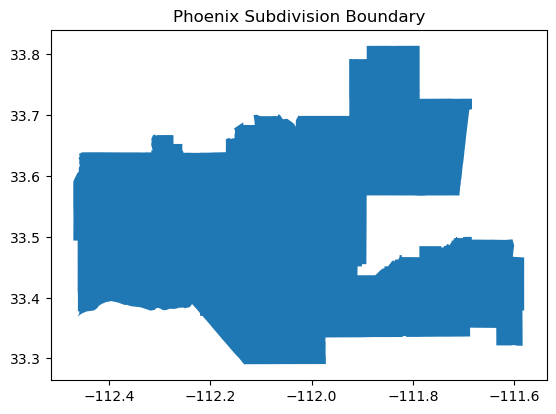

In [17]:
# Load data and filter to Phoenix
phoenix_shape = gpd.read_file('data/tl_2024_04_cousub/tl_2024_04_cousub.shp').query("NAME == 'Phoenix'")

phoenix_matched = phoenix_shape.to_crs(phoenix_2017.rio.crs)

# Take a look at the Phoenix county subdivision
phoenix_shape.plot()
plt.title("Phoenix Subdivision Boundary")

In [19]:
# Clip each raster to the Phoenix subdivision:
phoenix_2017 = phoenix_2017.rio.clip_box(*phoenix_matched.total_bounds).rio.clip(phoenix_matched.geometry)
phoenix_2020 = phoenix_2020.rio.clip_box(*phoenix_matched.total_bounds).rio.clip(phoenix_matched.geometry)

### Calculation of BII values 

To perform the BII >= 0.75 calculation, I create a boolean masks indicating where biodiversity intactness (BII) meets or exceeds the high-intactness threshold of 0.75 in each year. Then, I calculate it as a percentage.

In [34]:
# Create Boolean Mask
bii_2017 = phoenix_2017 >= 0.75
bii_2020 = phoenix_2020 >= 0.75

In [35]:
# Calculate the percentage of Phoenix pixels that have high BII (≥ 0.75)
pct_2017 = (bii_2017.sum() / bii_2017.count()) * 100
pct_2020 = (bii_2020.sum() / bii_2020.count()) * 100


print(f"2017 High-BII: {pct_2017.item():.2f}%")
print(f"2020 High-BII: {pct_2020.item():.2f}%")


2017 High-BII: 4.18%
2020 High-BII: 3.81%


In [37]:
# Mask out all pixels where no loss occurred
phoenix_loss = bii_2017 & (~bii_2020)
phoenix_loss_mask = phoenix_loss.where(phoenix_loss != 0)

### Create Visualization of Calculation Results

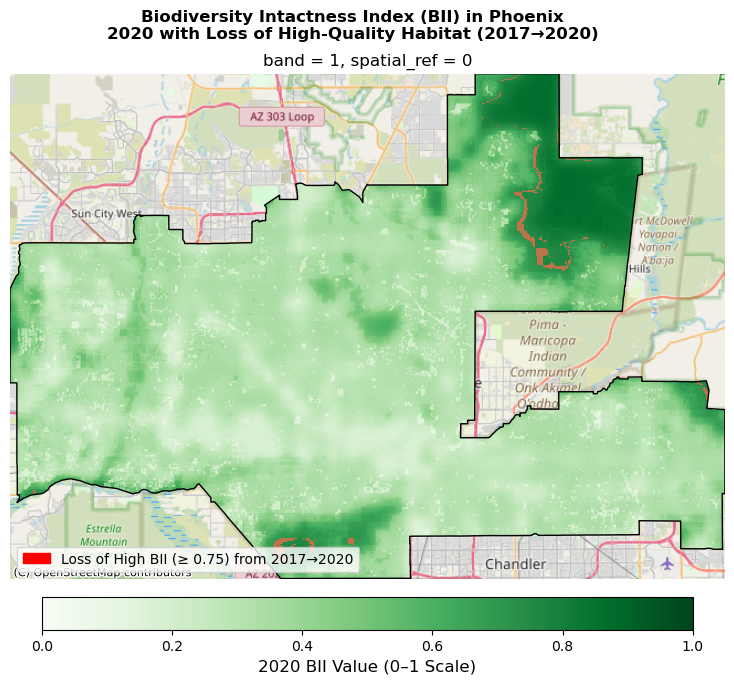

In [40]:

phoenix_2020_web = phoenix_2020.rio.reproject("EPSG:3857")
loss_web = phoenix_loss_mask.rio.reproject("EPSG:3857")
boundary_web = phoenix_shape.to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(12, 8))

# Title
plt.suptitle("Biodiversity Intactness Index (BII) in Phoenix\n2020 with Loss of High-Quality Habitat (2017→2020)",
             fontsize=12, fontweight="bold", y=0.96)

# Plot background 2020 BII raster
im = phoenix_2020_web.plot(
    ax=ax,
    cmap="Greens",
    vmin=0,
    vmax=1,
    add_colorbar=False
)

# Add a colorbar with ticks
cbar = fig.colorbar(im, ax=ax, shrink=0.7, pad=0.03, orientation="horizontal")
cbar.set_label("2020 BII Value (0–1 Scale)", fontsize=12)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.ax.tick_params(labelsize=10)

# Plot loss mask (red)
loss_web.plot(
    ax=ax,
    cmap="Reds",
    alpha=0.7,
    add_colorbar=False
)

# City boundary
boundary_web.boundary.plot(ax=ax, color="black", linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Legend using mpatches
loss_patch = mpatches.Patch(color='red', label="Loss of High BII (≥ 0.75) from 2017→2020")
ax.legend(handles=[loss_patch], loc="lower left")

# Clean up axes
ax.set_axis_off()

plt.show()


### Map Analysis 
The map shows that the Phoenix subdivision experienced a general decline in high-intactness habitat (dark green) from 2017 to 2020, dropping from 4.18% to 3.81% of the total city area. Although the overall percentages are small, the spatial pattern of losses highlights localized areas where ecological conditions may be worsening. These localized areas likely correspond to the known urban expansion occuring across Arizona. Some of the area that was once suitable as habitat for animal species and plant life has disppeared as unaltered land once covered with plant life is turned into residential and commercial development. 

The red coloring in the map represents areas where ecological integrity has fallen below the high-quality threshold. It is almost certain that over time, larger areas of Phoenix will demonstrate similar degradation of ecological integrity if urban development continues at similar rates.